In [1]:
import os
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Input, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.saving import load_model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [2]:
data_path ='KaggleDataset'
train_dataset = os.path.join(data_path, 'train')
test_dataset = os.path.join(data_path, 'test')
val_dataset = os.path.join(data_path,'val')

In [3]:
print('train exists:', os.path.exists(train_dataset))
print('test exists:', os.path.exists(test_dataset))
print('val exists:', os.path.exists(val_dataset))
print('\nfolders int train:', os.listdir(train_dataset) if os.path.exists(train_dataset) else 'no train folder')
print('\nfolders int test:', os.listdir(test_dataset) if os.path.exists(test_dataset) else 'no test folder')
print('\nfolders int val:', os.listdir(val_dataset) if os.path.exists(val_dataset) else 'no validation folder')

train exists: True
test exists: True
val exists: True

folders int train: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

folders int test: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

folders int val: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [4]:
# data generation to reduce overfitting
train_revise = ImageDataGenerator(
    rescale = 1./255, #normalize all the images
    width_shift_range = 0.1, #shift the image on the x-axis
    height_shift_range = 0.1, #shift the image on the y-axis
    shear_range=0.1,#tilting the image along one axis
    zoom_range=0.1,#zoom in by 10%
    horizontal_flip=True,#flips the image left-right
    fill_mode='nearest'#if there is an empty value, fill it with the nearest pixel. 
)

In [5]:
IMAGE_SIZE = (224,224)

In [6]:
val_test_revise = ImageDataGenerator(
    rescale=1./255
)

# import the dataset
train_imported = train_revise.flow_from_directory(
    train_dataset,
    target_size = IMAGE_SIZE,
    batch_size = 20
)
val_imported = val_test_revise.flow_from_directory(
    val_dataset,
    target_size = IMAGE_SIZE,
    batch_size = 20,
    shuffle = False
)
test_imported = val_test_revise.flow_from_directory(
    test_dataset,
    target_size = IMAGE_SIZE,
    batch_size = 20,
    shuffle = False
)

Found 6327 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 778 images belonging to 4 classes.


In [23]:
model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding ='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=100, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', name="last_conv"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))


model.add(GlobalAveragePooling2D())
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.0004)))
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax', name="Predictions"))



In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 100)       │          57,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last_conv (Conv2D)                   │ (None, 56, 56, 128)         │         115,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Predictions (Dense)                  │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 210,216 (821.16 KB)

 Trainable params: 209,832 (819.66 KB)

 Non-trainable params: 384 (1.50 KB)

In [24]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [26]:
checkpoint_path ='model_1.keras'
callbacks =[ 
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, verbose=1)]

In [27]:
model.fit(x=train_imported,
          steps_per_epoch=len(train_imported),
          validation_data=val_imported,
          validation_steps=len(val_imported),
          callbacks=callbacks,
          epochs=15,
          verbose=2,
         )

Epoch 1/15

Epoch 1: val_accuracy improved from None to 0.36842, saving model to model_1.keras
317/317 - 611s - 2s/step - accuracy: 0.7308 - loss: 0.7589 - val_accuracy: 0.3684 - val_loss: 1.4886 - learning_rate: 1.0000e-04
Epoch 2/15

Epoch 2: val_accuracy improved from 0.36842 to 0.50000, saving model to model_1.keras
317/317 - 598s - 2s/step - accuracy: 0.8239 - loss: 0.5118 - val_accuracy: 0.5000 - val_loss: 0.9611 - learning_rate: 1.0000e-04
Epoch 3/15

Epoch 3: val_accuracy improved from 0.50000 to 0.68421, saving model to model_1.keras
317/317 - 597s - 2s/step - accuracy: 0.8524 - loss: 0.4386 - val_accuracy: 0.6842 - val_loss: 0.8506 - learning_rate: 1.0000e-04
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.68421
317/317 - 664s - 2s/step - accuracy: 0.8761 - loss: 0.3870 - val_accuracy: 0.6053 - val_loss: 1.6871 - learning_rate: 1.0000e-04
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.68421
317/317 - 664s - 2s/step - accuracy: 0.8947 - loss: 0.3434 - val_ac

In [45]:
model.save("model_1.keras")

In [31]:
imgs, labels = next(train_imported)

In [32]:
#visualize the data
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

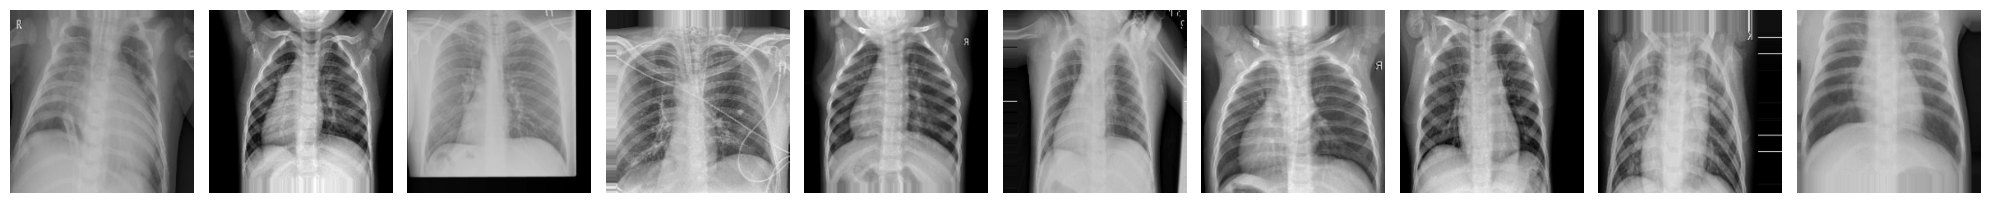

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [33]:
plotImages(imgs)
print(labels)

In [28]:
import numpy as np
import itertools

In [29]:
predictions = model.predict(x=test_imported, steps=len(test_imported),verbose=0) 

In [30]:
np.round(predictions)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(778, 4), dtype=float32)

In [31]:
cm = confusion_matrix(y_true=test_imported.classes, y_pred=np.argmax(predictions, axis=-1))

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
test_imported.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

Confusion matrix, without normalization
[[104   3   0   2]
 [  9 220   6   0]
 [  6 130 255   0]
 [  5   0   1  37]]


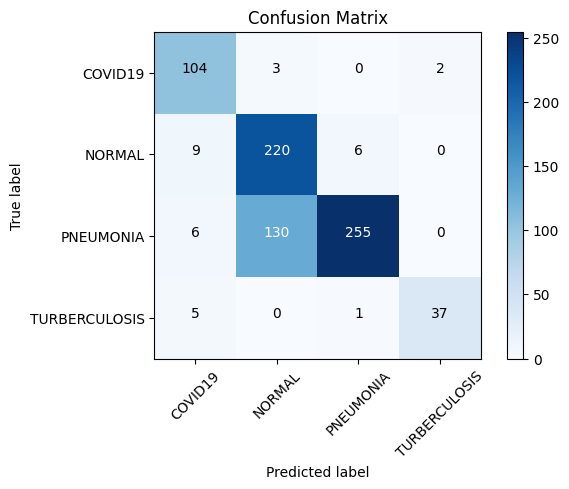

In [34]:
cm_plot_labels =['COVID19','NORMAL','PNEUMONIA','TURBERCULOSIS']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [41]:
print(os.path.exists('model_1.keras'))

True


In [42]:
last_conv_layer_name = "block14_sepconv2"

In [43]:

#Display
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
import matplotlib as mpl
import tensorflow as tf


model_builder = keras. applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [48]:
#image path
img_path = "KaggleDataset/test/COVID19/COVID19(460).jpg"
size = (299,299)

#load the image
img = image.load_img(img_path, target_size=(299,299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
ime_array = img_array / 255.0

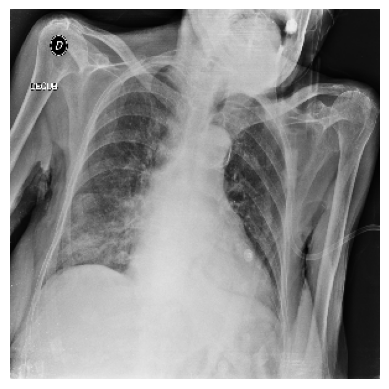

In [89]:
#visualize
plt.imshow(img)
plt.axis("off")
plt.show()